In [ ]:
import numpy as np
import pylab as plt
import matplotlib.ticker as ticker
import random
from collections import deque
from scipy import signal
import math
from scipy.stats import norm
import ast

In [ ]:
# from numpy.core.function_base import linspace
class hh_network:


  V_in=[]
  N_in=[]
  M_in =[]
  H_in = []

  tmin = 0.0
  tmax = 600.0
  T = np.linspace(tmin, tmax, 10*1000)
  h = (tmax - tmin)/T.size


  network=[]
  Number = len(network)
  synchrony = -1

  mean_domain_gaussion=0

  # g_feedback = None
  # type_feedback = None
  # delay_feedback = None
  # S = np.zeros (T.size)
  # I_feedback =[]
  # I_feedback.append(0.00)



  @classmethod
  def sample_init(cls, v_in, n_in, m_in, h_in,start,end):
    hh_network.V_in = v_in
    hh_network.N_in = n_in
    hh_network.M_in = m_in
    hh_network.H_in = h_in
    hh_network.start = start
    hh_network.end = end
    # hh_network.g_feedback = g_feedback
    # hh_network.type_feedback = type_feedback
    # hh_network.delay_feedback = int((len(hh_network.T)*delay_feedback)/hh_network.tmax)

  def __init__(self, delay, g_syn, synaptic_type, I_external, index, g_feedback , type_feedback, delay_feedback):
    self.c_m  = 1
    self.g_na = 120.0
    self.g_k = 36.0
    self.g_l = 0.3
    self.Beta_syn = 0.3
    self.Beta_syn_f= 0.4
    self.vk = -72
    self.vna = 55
    self.vl = -50.6
    #--------------------
    hh_network.network.append(self)
    self.id = len(hh_network.network)-1
    self.Iext = []
    self.Iext.append(3)
    #-----------------------------------------
    self.delay = delay#آزایه به طول تعداد کل نورون های شبکه
    for i in range(len(self.delay)):
      if self.delay[i]!= None :
        self.hold = self.delay[i]
        self.delay[i] = int((len(hh_network.T)*self.delay[i])/hh_network.tmax)

      # print("the delay for %sth neuron to neuron %sht is: %s" %(self.id, i , self.delay[i]))

    self.g_syn = g_syn#آزایه به طول تعداد کل نورون های شبکه
    self.synaptic_type = synaptic_type
    self.I_external = I_external
    #---------------------------
    # item = np.random.randint(0,17)
    # index = int(( item * hh_network.T.size)/hh_network.tmax)

    # start = (hh_network.start*hh_network.tmax)/hh_network.T.size
    # end = (hh_network.end*hh_network.tmax)/hh_network.T.size
    # index = np.random.randint(hh_network.start-400, hh_network.start+400)

    index = int(( index * hh_network.T.size)/hh_network.tmax)

    self.V = np.zeros( hh_network.T.size)
    self.V[0] = -61.3285071597725

    self.N = np.zeros( hh_network.T.size)
    self.N[0] = 0.37557270492791006

    self.M = np.zeros(hh_network.T.size)
    self.M[0] = 0.08081698852095204

    self.H = np.zeros (hh_network.T.size)
    self.H[0] = 0.463910771794007

    self.Sij = np.zeros((hh_network.Number, hh_network.T.size))
    self.I_synaptic = []
    self.I_synaptic.append(0.00)
    self.v_input=[]
    for i in range( hh_network.Number ):
        self.v_input.append(deque())
        # if(i != self.id):
        #   self.v_input[i].append(0.00)

    # self.v_input = np.zeros( hh_network.Number)
    #---------------------------------
    self.v_fdb_delay = None

    self.g_feedback = g_feedback
    self.type_feedback = type_feedback
    # self.delay_feedback = delay_feedback
    if delay_feedback!=None:
      self.delay_feedback = int((len(hh_network.T)*delay_feedback)/hh_network.tmax)
      # print(self.delay_feedback )
    else:
      self.delay_feedback = delay_feedback
    self.S = np.zeros (hh_network.T.size)
    self.I_feedback =[]
    self.I_feedback.append(0.00)


  def alpha_Syn(self, V_syn, tag): #j
    if tag=='syn':
      return ((2)* ( (1+ np.tanh((V_syn/10)))/2 )  )
    if tag=='feed':
      return ((8)* ( (1+ np.tanh((V_syn/10)))/2 )  )

  def alpha_n(self, V):
      return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))
      # return (0.1 - (0.01*V)) / (np.exp(1.0 - (0.1 * V)) - 1.0)
  def beta_n(self, V):
    return 0.125*np.exp(-(V+65) / 80.0)
    # return 0.125 * np.exp(-V / 80.0)

  def alpha_m(self, V):
    return  0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))
    # return ( 2.5 - (0.1*V)) / (np.exp(2.5 - (0.1 * V)) - 1.0)
  def beta_m(self, V):
    return 4.0*np.exp(-(V+65.0) / 18.0)
    # return 4.0 * np.exp(-V/ 18.0)

  def alpha_h(self, V):
    return 0.07*np.exp(-(V+65.0) / 20.0)
    #  return 0.07 * np.exp(-V / 20.0)
  def beta_h(self, V):
    return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))
    # return 1.0 / (np.exp(3.0 - (0.1 * V)) + 1.0)
#=============================================
  def n_inf(self, V):
          return self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
  def Tu_n(self, V):
          return 1/ (self.alpha_n(V) + self.beta_n(V))

  def m_inf(self, V):
          return self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
  def Tu_m(self, V):
          return 1/ (self.alpha_m(V) + self.beta_m(V))

  def h_inf(self, V):
          return self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
  def Tu_h(self, V):
          return 1/ (self.alpha_h(V) + self.beta_h(V))
#========================================================
  def I_Na(self, V, m, h):
    return self.g_na * m**3 * h * (V - self.vna)

  def I_K(self, V, n):
    return self.g_k  * n**4 * (V - self.vk)

  def I_L(self, V):
    return self.g_l * (V - self.vl)

  def I_inj(self, t,I,A):
    # return I , np.random.normal(0,0.1)
    if 300<t<303:
     return 20*I , np.random.normal(0,0.1)
    else:
      return I , np.random.normal(0,0.1)
      # if 200 > t :
      #     return I , np.random.normal(0,0.1)

      # if 200 <= t < 220 :
      #     i = (3/20)*t - 27
      #     return i , np.random.normal(0,0.1)

      # if 220 <= t <= 600:
      #     return 2*I , np.random.normal(0, 0.1)

      # if 600< t <= 620 :
      #     i = (-3/20)*t + 96
      #     return i , np.random.normal(0,0.1)

      # if t>600:
      #   return I ,np.random.normal(0, 0.1)
      # return I ,np.random.normal(0, 0.5)

  def I_syn(self, V, S_ij, g_syn, type_synaptic, tag):
    if tag=='syn':
      return -g_syn * S_ij * (-55 - type_synaptic)
    if tag=='feed':
      return -g_syn * S_ij * (-55 - type_synaptic)
      # return g_syn
#==========================================================
  def dn(self, V,n):
    return (self.alpha_n(V)*(1-n)) - (self.beta_n(V)*n )

  def dm(self, V,m):
    return (self.alpha_m(V)*(1-m)) - (self.beta_m(V)*m)

  def dh(self, V,h):
    return (self.alpha_h(V)*(1-h)) - (self.beta_h(V)*h)

  def ds_ij(self, V_syn, S_ij,tag):
    if tag == 'syn':
      return (self.alpha_Syn(V_syn,'syn')* (1-S_ij) - self.Beta_syn*S_ij)
    if tag == 'feed':
      return (self.alpha_Syn(V_syn, 'feed')* (1-S_ij) - self.Beta_syn_f*S_ij)

  def dv(self, t):
    d_v=0.000
    I_synaptic=0.00

    n = self.N[t]
    m = self.M[t]
    h = self.H[t]
    V = self.V[t]

    for j in range(hh_network.Number):

        if self.g_syn[j] != None :
          sij = self.Sij[j][t] #sij
          g_syn = self.g_syn[j]
          d_v = d_v + self.I_syn(V , sij, g_syn, self.synaptic_type[j], 'syn')
          I_synaptic = d_v

    i_feedback=0
    if self.g_feedback != None : #*********************************************
          s = self.S[t] #*********************************************
          g_syn = self.g_feedback #*********************************************
          i_feedback = self.I_syn(V , s, g_syn, self.type_feedback, 'feed') #*********************************************
          d_v = d_v + i_feedback #*********************************************


    i_external, noise = self.I_inj(self.T[t], self.I_external, 10.0)

    d_v = d_v + i_external - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)
    d_v = d_v/self.c_m


    return d_v, I_synaptic, noise, i_external, i_feedback

#==============================================================
  def solve(self,t):
    # print("hi parnian i am in solve and my id is:%s and the len_network:%s"  %(self.id ,hh_network.Number))
    for j in range(hh_network.Number): #for any neuron in network
        if( len(self.v_input[j]) != 0): #using queue اگر صف مربوط به نورون پیش سیناپسی خالی نبود
          hold = self.v_input[j].popleft()#از سر صف یک مقدار ولتاژ پیش سیناپسی برمیداریم
          # print("my id is:%s and iam in solve in sij and my v_input %s is %s" %(self.id,j,  hold))
          self.Sij[j][t+1] = self.Sij[j][t] + self.h * self.ds_ij(hold, self.Sij[j][t], 'syn' )#sij
          # self.v_input[j] = None
    tag = False
    v_mean = 0 #*********************************************
    for k in range(hh_network.Number): #*********************************
      if hh_network.network[k].v_fdb_delay!=None: #*******************************
        tag = True
        v_mean = v_mean + hh_network.network[k].v_fdb_delay #********************************
      # else: #*********************************************
        # print("rid")  #*********************************************
    v_mean= v_mean/hh_network.Number #*********************************************
    if tag == True :
       self.S[t+1] = self.S[t] + self.h * self.ds_ij(v_mean, self.S[t] ,'feed')#sij#************************

    self.N[t+1] = self.N[t] + self.h * self.dn( self.V[t] ,self.N[t] ) #n
    self.M[t+1] = self.M[t] + self.h * self.dm( self.V[t] ,self.M[t] ) #m
    self.H[t+1] = self.H[t] + self.h * self.dh( self.V[t] ,self.H[t] ) #n
    d_v, I_synaptic, noise, i_external, i_feedback= self.dv(t)
    self.I_synaptic.append(I_synaptic)

    self.I_feedback.append(i_feedback)
    self.Iext.append(noise + i_external)
    self.V[t+1] = self.V[t] + self.h *  d_v  + math.sqrt(self.h)*noise #v
    #--------------------------------------------------------------
    for i in range(hh_network.Number):
        if self.delay[i]!= None:
          if self.delay[i]>=0:
            # print("hi iam neuron %s and my delay_index is: %s" %(self.id, self.delay))
            hh_network.network[i].v_input[self.id].append(self.V[self.delay[i]])
            # print("hi iam neuron %sth and my input to neuron %sth is:%s" %(self.id, i ,hh_network.network[i].v_input))
            self.delay[i] = self.delay[i]+1
          else:
            self.delay[i] = self.delay[i]+1
            # hh_network.network[i].v_input[self.id] = None
    if(self.delay_feedback !=hh_network.T.size):
      if self.delay_feedback!=None: #*********************************************
        if self.delay_feedback >=0 : #********************************************
          self.v_fdb_delay = self.V[self.delay_feedback] #*********************************************
          self.delay_feedback =self.delay_feedback +1 #*********************************************
        else:
          self.delay_feedback =self.delay_feedback +1 #*********************************************

    return True

  def Spikes(self):
      Tag_increase = False
      Tag_decrease = False
      t = []
      vt = []
      V = np.array(self.V)
      P=0

      for i in reversed(range(V.size)) :
        if (i==0): break
        if(Tag_increase == False):
          if(V[i]>V[i-1]):
            Tag_increase = True

        if(Tag_decrease == False ):
          if(V[i]<V[i-1]):
            Tag_decrease=True

        if(Tag_increase==True):
          if(Tag_decrease==True):
            Tag_decrease=False
            Tag_increase=False
            if(V[i]>=20):
              # I = (i*tmax)/T.size
              t.append(i)  #دقیقا زمان اسپایک رو برمیگردونه روی اسکیل T
              # vt.append(V[i])
              # if(len(t)==10):
              #   break
      return t

  def show_single_neuron(self, pattern):

      if  pattern =='n':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.N, label= "")
          ax.set_xlabel('time (ms)')
          ax.set_ylabel('N (probility )')
          title= "n_time" + str(self.id)
          ax.set_title( title)
          plt.grid()

      if  pattern =='m':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.M, label= "")
          ax.set_xlabel('time(ms)')
          ax.set_ylabel('M (probility)')
          title= "m_time" + str(self.id)
          ax.set_title( title)
          plt.grid()

      if  pattern == 'h':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.M, label= "")
          ax.set_xlabel('time(ms)')
          ax.set_ylabel('H (probility)')
          title= "h_time" + str(self.id)
          ax.set_title(title)
          plt.grid()

      if  pattern == 'v':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.V, label= "")
          ax.set_xlabel('time')
          ax.set_ylabel('V (mv)')
          title= "voltage" + str(self.id)
          ax.set_title(title)
          plt.grid()

      if  pattern == 'n,m,h':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.V, label= "")#whatttt wrong
          ax.set_xlabel('time')
          ax.set_ylabel('N,M,H')
          title= "n,m.h" + str(self.id)
          ax.set_title(title)
          plt.grid()

      if  pattern == 'I_syn':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.I_synaptic, label= "")
          ax.set_xlabel('time')
          ax.set_ylabel('I_syn')
          title= "total I_syn" + str(self.id)
          ax.set_title(title)
          plt.grid()

      if  pattern == 'I_feedback':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.I_feedback, label= "")
          ax.set_xlabel('time')
          ax.set_ylabel('I_syn')
          title= "I_feedback" + str(self.id)
          ax.set_title(title)
          plt.grid()

      if  pattern == 'v, I_syn':
          fig, ax = plt.subplots(figsize=(12, 7))
          hold = np.array(self.I_synaptic)
          ax.plot(hh_network.T , self.V, label= "voltage")
          ax.plot(hh_network.T ,  20*hold , label= "I_synaptic")
          ax.set_xlabel('time')
          ax.set_ylabel('I_syn and voltage')
          # title= "total I_syn" + str(self.id)
          # ax.set_title(title)
          plt.grid()

      if  pattern == 's':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.Sij[0,:], label= "voltage")

          ax.set_xlabel('time')
          ax.set_ylabel('s')
          # title= "total I_syn" + str(self.id)
          # ax.set_title(title)          plt.grid()

      if  pattern =='I':
          fig, ax = plt.subplots(figsize=(12, 7))
          ax.plot(hh_network.T , self.Iext , label= "")
          ax.set_xlabel('time (ms)')
          ax.set_ylabel('I external')
          title= "I_time" + str(self.id)
          ax.set_title( title)
          plt.grid()
      return hh_network.T , self.Iext, self.V

  @classmethod
  def run_network(cls):
    # print("hi iam in run_network and i see len_network:%s" %(len(hh_network.network)))
    for t in range(hh_network.T.size-1): #for any t in T do
      for i in range(len(hh_network.network)): #for any neurons in network
        hh_network.network[i].solve(t) #do solve for neuron ith

  @classmethod
  def show_network(cls):
    fig, ax = plt.subplots(figsize=(12, 7))
    for p in range(hh_network.Number):
      ax.plot(hh_network.T, hh_network.network[p].V , label= "V")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    tittle = 'Action patential ' + "delay:" + str(hh_network.network[0].hold)
    ax.set_title(tittle)
    plt.grid()

  @classmethod
  def show(cls, X, X_start, X_end ,Y , Y_start , Y_end):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(X[X_start:X_end], Y[Y_start:Y_end] , label= "")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(":)")
    plt.grid()

  @classmethod
  def del_network(cls):
    # for i in range( len(hh_network.network)-1):
    #   del hh_network.network[i]

    hh_network.network=[]
    hh_network.Number = 0
    print("the network deleted! :)")

  @classmethod
  def raster(cls):

    spike = []
    # spike = np.array(spike)
    N=hh_network.Number
    for p in range(N):
      hold = hh_network.network[p].Spikes()
      # Hold = np.array(hold)
      # print(Hold.shape)
      for j in range(len(hold)):
        hold[j] = (hold[j]*hh_network.tmax)/hh_network.T.size

      Hold = np.array(hold)
      spike.append(hold)

    # colors1 = ['C{}'.format(i) for i in range(N)]
    # lineoffsets1 = []
    # linelengths1 = []
    # for i in range(N):
    #   lineoffsets1.append(2*i)
    #   linelengths1.append(1)
    lineoffsets1 = [i + 1 for i in range(N)]     # شروع از 1 برای مطابقت با محور y
    linelengths1 = [0.6] * N

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.eventplot(spike, lineoffsets=lineoffsets1,
                        linelengths=linelengths1)
    tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
    ax.set_title(tittle)
    ax.set_xlabel('Time(s)')
    ax.set_ylabel('neuron')
    return spike, lineoffsets1,linelengths1

  @classmethod
  def network_activity(cls, ssspike, lineoffsets1,linelengths1):
    spike = np.array([])
    N=hh_network.Number
    for p in range(N):
      hold = hh_network.network[p].Spikes()
      for j in range(len(hold)):
        hold[j] = (hold[j]*hh_network.tmax)/hh_network.T.size
      Hold = np.array(hold)
      # spike.append(hold)
      spike = np.concatenate((spike,Hold))
    # print(len(spike))
    bins =[]
    bin= 100
    for i in range(bin):
      # bins.append([])
      bins.append(0)


    H= hh_network.tmax/bin #طول بین
    for t in spike:
      for i in range(bin):
        if i*H <=t< i*H+H:
          # bins[i].append(t)
          bins[i]= bins[i]+1
          break

    # print( "bins[1]: %s" %bins[1])
    counter=0
    item=0
    hh_network.mean_domain_gaussion=0
    for k in range(50, bin):
      if bins[k]!=0:
        item = item+bins[k]
        counter = counter+1
    hh_network.mean_domain_gaussion = item/counter
    print(hh_network.mean_domain_gaussion)



    # print(len(bins))
    # print(bins)
    H_ = int((H*hh_network.T.size)/hh_network.tmax)
    Q=[]
    for j in range(bin):
          Q.append(np.zeros (hh_network.T.size))

    for i in range(bin):
      for j in range(i*H_ ,i*H_+H_):
        Q[i][j] = (100*bins[i])/hh_network.Number*H


    P=[]
    for i in range(bin):
      mean = (i*H + i*H+H)/2
      sigma = math.sqrt(H)
      # print ("bin %s   mean: %s, sigma: %s" %(i, mean, sigma))
      p = np.array ( norm.pdf( hh_network.T,mean,sigma ))
      P.append(p)

    C =[]
    for i in range(bin):
      kernel = np.array(P[i])
      pulse = np.array(Q[i])
      c=kernel*pulse
      # gggggg = np.convolve(Q[2] , P[2], 'same')
      C.append(c)

    total = np.zeros_like(C[0])
    for i in range(len(C)):
      # plt.plot(hh_network.T, P[i], 'k', linewidth=2)
      total = C[i]+ total
    # print(len(total))
    item = int(total.size/2)
    A=total[item :]
    fft = np.fft.fft(A)
    psd = (fft*np.conj(fft))/item
    # number = total.size
    # f = np,linspace(0,1/(hh_network.tmax/hh_network.T.size),number)
    f = np.fft.fftfreq(fft.size, hh_network.h*(1/1000)) #*(1/1000)
    # x_mag = np.abs(fft)/(item)
    l = np.arange(1, np.floor(item/2),dtype='int')


    fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(5, 4.6),
                               sharex=True,
                               gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.1})

    # fig, ax = plt.subplots(figsize=(5, 3))
    # plt.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # ax1.set_xticks([])     # حذف تیک‌های محور X
    # ax1.set_xticklabels([])  # حذف عددهای زیر تیک‌ها (در صورت وجود)
    # ax1.yticks(ticks = np.arange(1, 11, 2), fontsize=12, family='Time Roman')
    for i, s in enumerate(ssspike):
        if len(s) == 0:
            print(f"Neuron {i+1} has no spikes")

    ax1.eventplot(ssspike, lineoffsets=lineoffsets1,
                        linelengths=linelengths1, colors='darkblue',)
    # tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
    # ax.set_title(tittle)
    # ax.set_xlabel('Time(ms)')
    # ax1.ylim(1,11)

    # fig, ax = plt.subplots(figsize=(5, 1.5))
    # tittle = 'network activity'
    # ax.set_title(tittle)
    # ax2.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # ax1.set_yticks(np.arange(1, 100, 20))  # تعیین محل تیک‌ها
    ax1.set_yticks([1, 50, 100])
    ax1.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax1.get_yticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    # ax2.yticks(fontsize=12, family='Time Roman')
    # ax2.set_xlabel('Time (ms)', fontsize=20,family='Time Roman')
    # ax.set_ylabel('A (mV)', fontsize=20,family='Time Roman')
    ax2.plot(hh_network.T, total ,color='red', linewidth=2)

    ax2.set_xticks(np.arange(100, 501, 100))  # تعیین محل تیک‌ها
    ax2.set_xlabel("Time (ms)", fontsize=25,family='Time Roman')
    ax2.tick_params(axis='x', labelsize=17)  # اندازه فونت
    ax2.set_yticks([0, 45, 90])
    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax2.get_xticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

    # ax2.set_yticks(np.arange(0, 20, 5))  # تعیین محل تیک‌ها
    ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax2.get_yticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    ax2.set_xmargin(0)
    ax2.set_ymargin(0)
    ax1.set_xmargin(0)
    ax1.set_ymargin(0)
    ax2.set_xlim(100, 500)
    ax2.set_ylim(0, 91)
    # plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
    # plt.plot(hh_network.T, P[2], color='red', linewidth=2)
    # plt.grid()
    plt.show()

    # f_plot = f[: int(item/2+1)]
    # x_mag_plot = 2*x_mag[: int(item/2+1)]
    # x_mag_plot[0] = x_mag_plot[0]/2

    # index = psd[l].argmax()
    # print("network rate: %s" %f[l][index])

    # fig1, ax1 = plt.subplots(figsize=(7, 5))
    # tittle = 'fft'
    # ax1.set_title(tittle)

    # plt.plot(f[l],psd[l])
    # plt.xlim(0,100)
    # plt.grid()
    # plt.show()

    # fig, ax = plt.subplots(figsize=(7, 5))
    # tittle = 'network activity'
    # ax.set_title(tittle)
    # ax.set_xlabel('Time(s)')
    # ax.set_ylabel('Htz')
    # plt.plot(hh_network.T, total ,color='red', linewidth=2)
    # # plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
    # # plt.plot(hh_network.T, P[2], color='red', linewidth=2)
    # plt.grid()
    # plt.show()
    # fig, (ax1, ax2) = plt.subplots(2, 1,
    #                            figsize=(5, 4.6),
    #                            sharex=True,
    #                            gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

    # # fig, ax = plt.subplots(figsize=(5, 3))
    # # plt.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # # ax1.set_xticks([])     # حذف تیک‌های محور X
    # # ax1.set_xticklabels([])  # حذف عددهای زیر تیک‌ها (در صورت وجود)
    # # ax1.yticks(ticks = np.arange(1, 11, 2), fontsize=12, family='Time Roman')
    # for i, s in enumerate(ssspike):
    #     if len(s) == 0:
    #         print(f"Neuron {i+1} has no spikes")

    # ax1.eventplot(ssspike, lineoffsets=lineoffsets1,
    #                     linelengths=linelengths1, colors='darkblue',)
    # # tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
    # # ax.set_title(tittle)
    # # ax.set_xlabel('Time(ms)')
    # # ax1.ylim(1,11)

    # # fig, ax = plt.subplots(figsize=(5, 1.5))
    # # tittle = 'network activity'
    # # ax.set_title(tittle)
    # # ax2.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # # ax1.set_yticks(np.arange(1, 100, 20))  # تعیین محل تیک‌ها
    # ax1.set_yticks([1, 50, 100])
    # ax1.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    # for label in ax1.get_yticklabels():
    #     label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    # # ax2.yticks(fontsize=12, family='Time Roman')
    # # ax2.set_xlabel('Time (ms)', fontsize=20,family='Time Roman')
    # # ax.set_ylabel('A (mV)', fontsize=20,family='Time Roman')
    # ax2.plot(hh_network.T, total ,color='red', linewidth=2)

    # ax2.set_xticks(np.arange(0, 401, 100))  # تعیین محل تیک‌ها
    # ax2.set_xlabel("Time (ms)", fontsize=25,family='Time Roman')
    # ax2.tick_params(axis='x', labelsize=17)  # اندازه فونت

    # # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    # for label in ax2.get_xticklabels():
    #     label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

    # # ax2.set_yticks(np.arange(0, 20, 5))  # تعیین محل تیک‌ها
    # ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    # for label in ax2.get_yticklabels():
    #     label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    # # ax2.set_xmargin(0)
    # # ax2.set_ymargin(0)
    # # ax2.ylim(0, 86)
    # # plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
    # # plt.plot(hh_network.T, P[2], color='red', linewidth=2)
    # # plt.grid()
    # plt.show()
    with open('total.txt', 'w') as f:
      for num in total:
        f.write(f"{num}\n")

    with open('T', 'w') as f1:
     for num in hh_network.T:
       f1.write(f"{num}\n")

    #ssspike, lineoffsets=lineoffsets1, linelengths=linelengths1

    with open('ssspike.txt', 'w') as f:
      for num in ssspike:
        f.write(f"{num}\n")

    with open('lineoffsets.txt', 'w') as f1:
     for num in lineoffsets1:
       f1.write(f"{num}\n")

    with open('linelengths1.txt', 'w') as f1:
     for num in linelengths1:
       f1.write(f"{num}\n")


    # فرض: T, Iext, V موجودن





    # Std=[]
    # # # x = np.linspace(0, , 200)
    # for i in range(bin):
    #   if bins[i]!=0:
    #     mean = ((i*H)+ (i*H+H))/2
    #     std = hh_network.Number/bins[i]
    #     Std.append(std)
    #     p = np.array(norm.pdf(hh_network.T, mean, std))
    #     P.append(p)
    #   # if len(bins[i])!=0:
    #   #   mu, std = norm.fit(bins[i])
    #   #   if std != None:
    #   #     if std != 0 :
    #   #       Std.append(std)

    #   #   if std!=0:
    #   #     p = np.array(norm.pdf(hh_network.T, mu, std))
    #   #     P.append(p)

    # Std = np.array([Std])
    # hh_network.synchrony = Std.mean()
    # print(hh_network.synchrony)


    # total = P[0]
    # for i in range(1,len(P)):
    #   # plt.plot(hh_network.T, P[i], 'k', linewidth=2)
    #   total = P[i]+ total
    # # print(len(total))

    # fig, ax = plt.subplots(figsize=(7, 5))
    # tittle = 'network activity'
    # ax.set_title(tittle)
    # ax.set_xlabel('Time(s)')
    # ax.set_ylabel('?')
    # plt.plot(hh_network.T, total, 'k', linewidth=2)
    # plt.grid()
    # plt.show()

  @classmethod
  def fano_factor(cls):
    fano = []
    for i in range(5000, hh_network.T.size):
      factor=0
      for j in range(hh_network.Number):
        hold = hh_network.network[j].V
        factor = factor + hold[i]
      factor = factor/hh_network.Number
      fano.append(factor)
    fano_f = np.array(fano)
    fanofactor = fano_f.var()/fano_f.mean()
    return fanofactor



the network deleted! :)
-68.27160179308969
0.4860785424756307
0.03469201245992532
0.33353990397692596


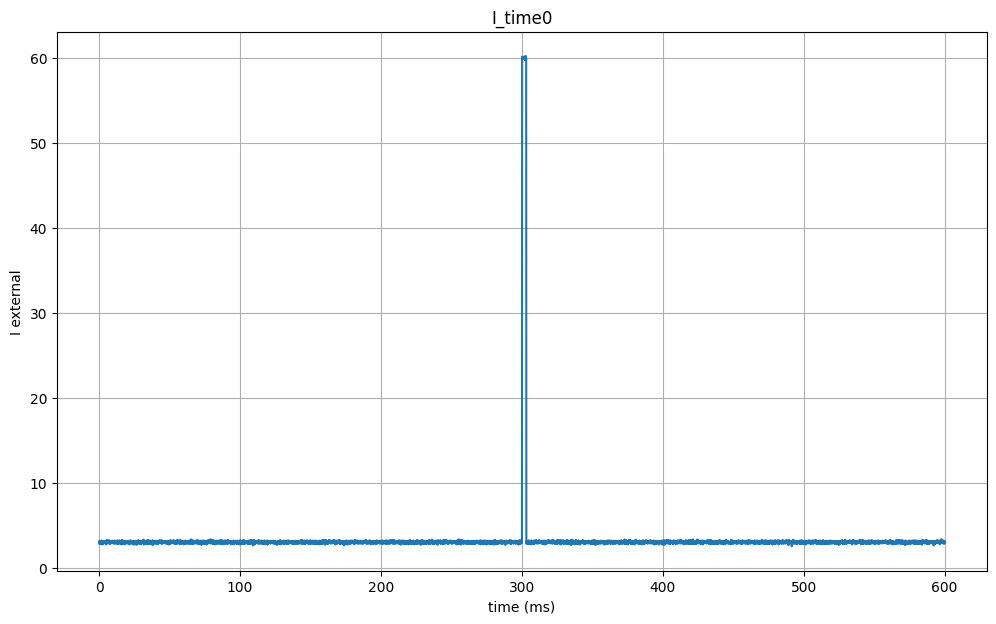

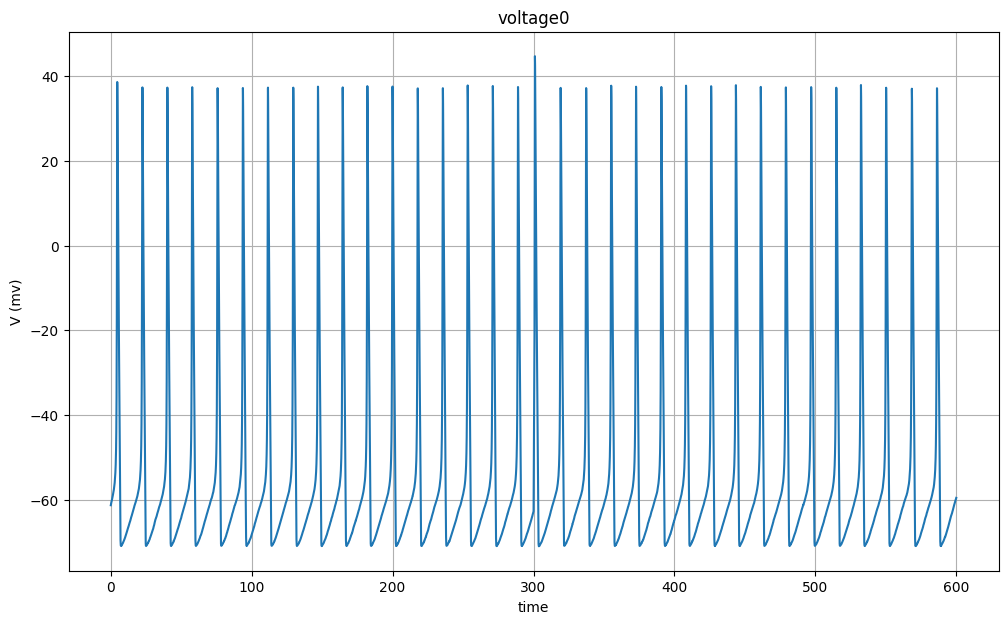

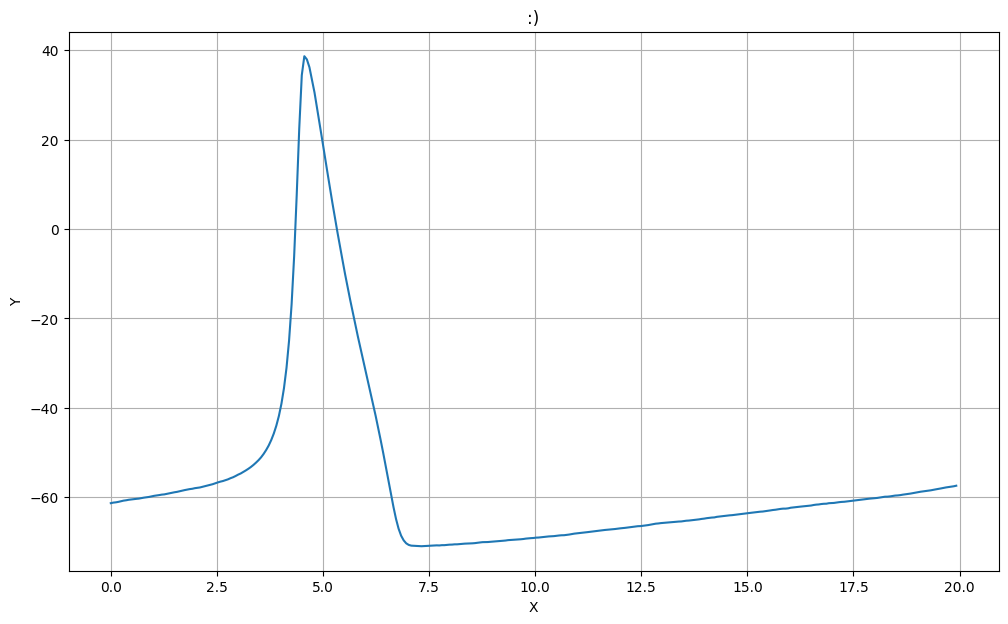

In [ ]:
hh_network.del_network()

hh_network.Number = 1
delay_0 = []
delay_0.append(None)
delay_0.append(None)#-100
g_syn_0 = []
g_syn_0.append(None)
g_syn_0.append(None)
synaptic_type_0 = []
synaptic_type_0 .append(None)
synaptic_type_0 .append(None)
I_external_0= 3.0
hh_network(delay_0, g_syn_0, synaptic_type_0, I_external_0,1, None, None, None)
hh_network.run_network()
T ,Iext, V= hh_network.network[0].show_single_neuron('I')
T ,Iext, V=hh_network.network[0].show_single_neuron('v')

end = int((20*len(hh_network.T))/hh_network.tmax)
hh_network.show( hh_network.T, 0 , end ,hh_network.network[0].V , 0 , end)

v_initial = hh_network.network[0].V
n_initial = hh_network.network[0].N
m_initial = hh_network.network[0].M
h_initial = hh_network.network[0].H

indd = (100*hh_network.T.size)/hh_network.tmax
indd = int(indd)
spike = hh_network.network[0].Spikes()
end = spike[0]
start = spike[1]
print(hh_network.network[0].V[indd])
print(hh_network.network[0].N[indd])
print(hh_network.network[0].M[indd])
print(hh_network.network[0].H[indd])

In [ ]:
import numpy as np
import pylab as plt
import matplotlib.ticker as ticker
import random
from collections import deque
from scipy import signal
import math
from scipy.stats import norm

from google.colab import files
uploaded = files.upload()

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# مسیر فایل فونت
font_path = '/content/time_romanbold.ttf'

# افزودن فونت به FontManager
fm.fontManager.addfont(font_path)

# ساخت FontProperties برای استفاده در نمودار
font_prop = fm.FontProperties(fname=font_path)

# نمایش نام فونت برای استفاده
print("نام فونت:", font_prop.get_name())




Saving time_romanbold.ttf to time_romanbold (1).ttf
نام فونت: Time Roman


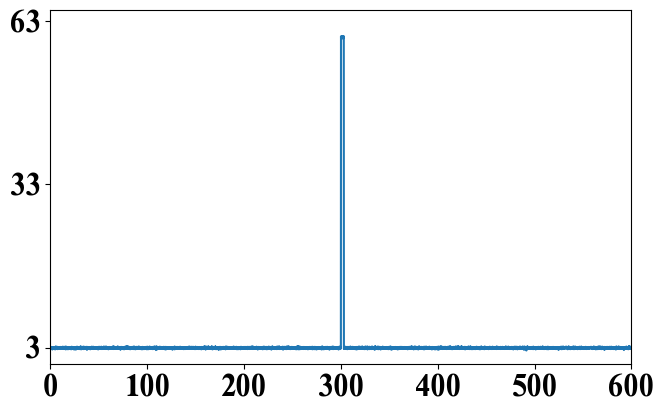

In [ ]:
T ,Iext, V

# fig, (ax1, ax2) = plt.subplots(2, 1,
#                             figsize=(6, 4.6),
#                             sharex=True,
#                             gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})

fig,ax1 = plt.subplots(figsize=(7.5, 4.6))
ax1.plot(T, Iext)
# tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
# ax.set_title(tittle)
# ax.set_xlabel('Time(ms)')
# ax1.ylim(1,11)

# fig, ax = plt.subplots(figsize=(5, 1.5))
# tittle = 'network activity'
# ax.set_title(tittle)
# ax2.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
# ax1.set_yticks(np.arange(0, 65, 0))  # تعیین محل تیک‌ها
# ax1.set_yticks([0, 2, 13])
ax1.set_yticks([3,33,63])
ax1.tick_params(axis='y', labelsize=22)  # اندازه فونت

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax1.get_yticklabels():
    label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax1.set_ylim(0, 65)
# ax2.yticks(fontsize=12, family='Time Roman')
# ax2.set_xlabel('Time (ms)', fontsize=20,family='Time Roman')
# ax.set_ylabel('A (mV)', fontsize=20,family='Time Roman')
# ax2.plot(T, V , linewidth=2, color= 'darkblue')

ax1.set_xticks(np.arange(0, 601, 100))  # تعیین محل تیک‌ها
# ax2.set_xlabel("Time (ms)", fontsize=18,family='Time Roman')
ax1.tick_params(axis='x', labelsize=22)  # اندازه فونت

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
# for label in ax2.get_yticklabels():
    # label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

for label in ax1.get_xticklabels():
    label.set_fontname('Time Roman')

# ax2.set_yticks(np.arange(-70, 55, 30))  # تعیین محل تیک‌ها
# ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت
# ax2.set_yticks([-60,-10, 40])

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
# for label in ax2.get_yticklabels():
#     label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


# ax2.set_xmargin(0)
# ax2.set_ymargin(0)
# ax2.set_ylim(-70, 50)
# plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
# plt.plot(hh_network.T, P[2], color='red', linewidth=2)
# plt.grid()
plt.show()



the network deleted! :)
36.875


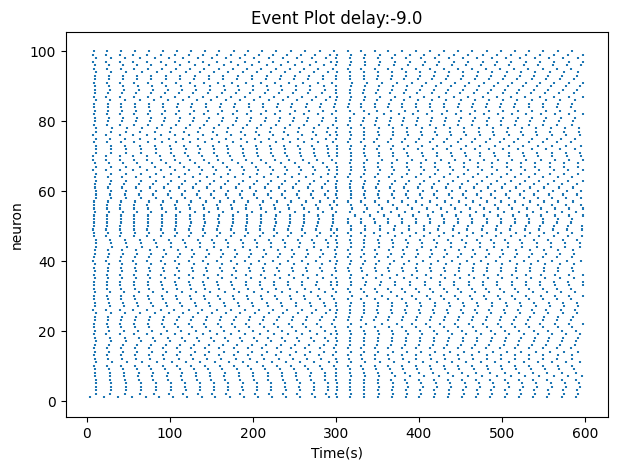

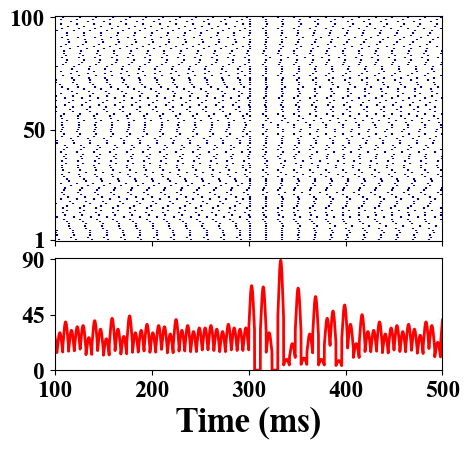

fano: -0.9873953746272799


In [ ]:
def main():
  g_feedback=0.08
  type_feedback= -100.00


  for i in np.arange(start=10, stop=11, step=1):
    delay_feedback= -4
    hh_network.del_network()
    hh_network.Number = 100

    hh_network.sample_init( v_initial, n_initial, m_initial, h_initial, start, end)


    index = []
    for j in range(hh_network.Number):
      if j==0:
       index.append(0)
      else:
        inx = random.uniform(10.74, 14.50)
        index.append(inx)

    for neuron in range(hh_network.Number):


      delay= []
      G_syn = []
      synaptic_type =[]
      for d in range(hh_network.Number):
        if neuron==d:
          delay.append(None)
        else:
           delay.append(-9.0)#-100

      for g in range(hh_network.Number):
        if neuron==g:
          G_syn.append(None)

        else:
          G_syn.append(0.0005)#-100

      for typ in range(hh_network.Number):
        if neuron==typ:
          synaptic_type.append(None)
        else:
          synaptic_type.append(0.00)#-100

      I_external= 3.00
      # index = np.random.randint(0,17)
      hh_network(delay, G_syn, synaptic_type, I_external, index[neuron], g_feedback, type_feedback, delay_feedback)

    hh_network.run_network()
    # hh_network.show_network()
    spike, lineoffsets1,linelengths1=hh_network.raster()
    hh_network.network_activity(spike, lineoffsets1,linelengths1)
    print("fano: %s" %(hh_network.fano_factor()))


    # hh_network.network[0].show_single_neuron('I_feedback')
    # hh_network.network[0].show_single_neuron('I_syn')

    # hh_network.network[5].show_single_neuron('I_feedback')




if __name__ == "__main__":
    main()    # hh_network.network[5].show_single_neuron('I_syn')


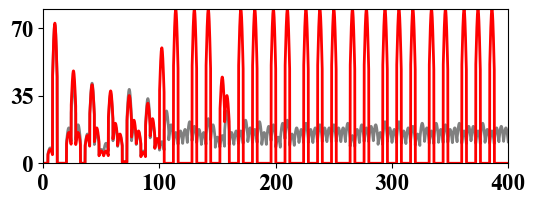

In [ ]:
with open('numbers_ex.txt', 'r') as f:
    Total = [float(line.strip()) for line in f]

with open('numbers1_ex.txt', 'r') as f1:
    T = [float(line.strip()) for line in f1]

with open('/content/numbers_ex (1).txt', 'r') as f3:
    Totalno = [float(line.strip()) for line in f3]

fig, ax2 = plt.subplots(figsize=(6, 2))


ax2.plot(T, Totalno ,color='grey', linewidth=2)
ax2.plot(T, Total ,color='red', linewidth=2)

ax2.set_xticks(np.arange(0, 401, 100))  # تعیین محل تیک‌ها
# ax2.set_xlabel("Time (ms)", fontsize=25,family='Time Roman')
ax2.tick_params(axis='x', labelsize=17)  # اندازه فونت

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax2.get_xticklabels():
    label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

# ax2.set_yticks(np.arange(0, 20, 5))  # تعیین محل تیک‌ها
ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت
ax2.set_yticks([0, 35, 70])
# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax2.get_yticklabels():
    label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


# ax2.set_xmargin(0)
# ax2.set_ymargin(0)
# ax2.ylim(0, 86)
# plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
# plt.plot(hh_network.T, P[2], color='red', linewidth=2)
# plt.grid()
ax2.set_xmargin(0)
ax2.set_ymargin(0)
plt.show()



In [ ]:
 # plt.show()
    fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(5, 4.6),
                               sharex=True,
                               gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

    # fig, ax = plt.subplots(figsize=(5, 3))
    # plt.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # ax1.set_xticks([])     # حذف تیک‌های محور X
    # ax1.set_xticklabels([])  # حذف عددهای زیر تیک‌ها (در صورت وجود)
    # ax1.yticks(ticks = np.arange(1, 11, 2), fontsize=12, family='Time Roman')
    for i, s in enumerate(ssspike):
        if len(s) == 0:
            print(f"Neuron {i+1} has no spikes")

    ax1.eventplot(ssspike, lineoffsets=lineoffsets1,
                        linelengths=linelengths1, colors='darkblue',)
    # tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
    # ax.set_title(tittle)
    # ax.set_xlabel('Time(ms)')
    # ax1.ylim(1,11)

    # fig, ax = plt.subplots(figsize=(5, 1.5))
    # tittle = 'network activity'
    # ax.set_title(tittle)
    # ax2.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
    # ax1.set_yticks(np.arange(1, 100, 20))  # تعیین محل تیک‌ها
    ax1.set_yticks([1, 50, 100])
    ax1.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax1.get_yticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    # ax2.yticks(fontsize=12, family='Time Roman')
    # ax2.set_xlabel('Time (ms)', fontsize=20,family='Time Roman')
    # ax.set_ylabel('A (mV)', fontsize=20,family='Time Roman')
    ax2.plot(hh_network.T, total ,color='red', linewidth=2)

    ax2.set_xticks(np.arange(0, 401, 100))  # تعیین محل تیک‌ها
    ax2.set_xlabel("Time (ms)", fontsize=25,family='Time Roman')
    ax2.tick_params(axis='x', labelsize=17)  # اندازه فونت

    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax2.get_xticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

    # ax2.set_yticks(np.arange(0, 20, 5))  # تعیین محل تیک‌ها
    ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت

    # تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
    for label in ax2.get_yticklabels():
        label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


    # ax2.set_xmargin(0)
    # ax2.set_ymargin(0)
    # ax2.ylim(0, 86)
    # plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
    # plt.plot(hh_network.T, P[2], color='red', linewidth=2)
    # plt.grid()
    plt.show()


['[597.54, 577.56, 557.82, 537.96, 518.82, 498.24, 478.74, 458.82, 438.9, 419.52, 399.42, 379.92, 360.06, 340.92, 320.82, 301.32, 292.98, 275.76, 258.6, 241.5, 224.4, 207.18, 190.14, 173.16, 156.0, 139.02, 121.98, 105.0, 88.14, 71.4, 54.66, 37.98, 21.42, 4.56]', '[597.42, 577.74, 557.88, 538.14, 518.4, 498.54, 478.62, 459.0, 439.08, 419.22, 399.78, 379.74, 360.3, 340.5, 321.3, 300.48, 283.38, 266.16, 248.88, 231.72, 214.68, 197.4, 180.12, 163.02, 145.68, 128.22, 111.0, 93.72, 76.44, 59.22, 42.42, 26.04, 9.42]', '[597.54, 577.5, 558.24, 537.96, 518.58, 498.24, 478.92, 458.76, 439.56, 422.28, 405.0, 387.66, 370.14, 352.26, 335.52, 299.22, 282.18, 265.2, 248.04, 230.94, 213.6, 196.38, 179.1, 162.12, 144.6, 127.5, 110.22, 93.18, 76.02, 58.86, 42.12, 25.8, 9.36]', '[597.96, 577.62, 558.06, 538.14, 518.58, 498.24, 478.8, 459.12, 438.9, 419.22, 399.6, 379.92, 360.18, 340.5, 320.64, 300.96, 288.0, 270.78, 253.32, 236.04, 219.06, 201.78, 184.44, 167.16, 150.18, 132.9, 115.38, 98.22, 81.0, 63.72

(0.0, 91.0)

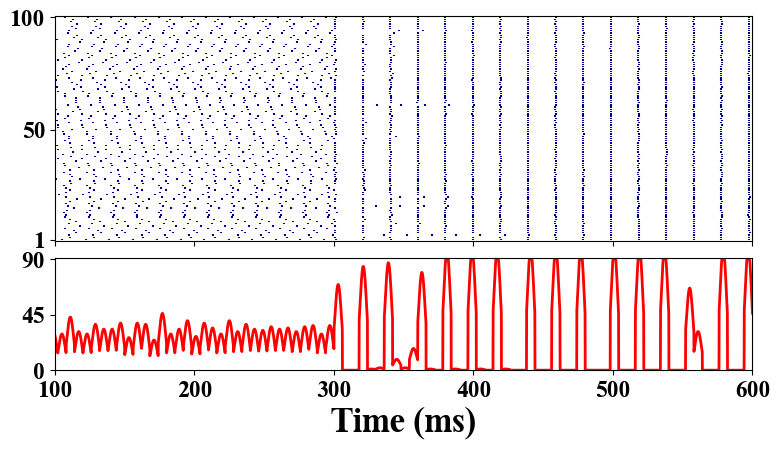

In [ ]:
with open('/content/T', 'r') as f:
    T = [float(line.strip()) for line in f]

with open('/content/total (2).txt', 'r') as f1:
    Total = [float(line.strip()) for line in f1]

with open('/content/ssspike (2).txt', 'r') as f2:
    ssspike = [line.strip() for line in f2]
print(ssspike)
import ast
ssspike = [ast.literal_eval(item) for item in ssspike]
# print(ssspike)  # [[1, 2], [3, 4], [5, 6]]


with open('/content/linelengths1 (2).txt', 'r') as f3:
    linelengths1 = [float(line.strip()) for line in f3]

with open('/content/lineoffsets (2).txt', 'r') as f4:
    lineoffsets = [float(line.strip()) for line in f4]

# with open('/content/T1', 'r') as ff:
#     T1 = [float(line.strip()) for line in ff]

# with open('/content/total1.txt', 'r') as ff1:
#     Total1 = [float(line.strip()) for line in ff1]

# with open('/content/ssspike1.txt', 'r') as ff2:
#     ssspike1 = [line.strip() for line in ff2]


# ssspike1 = [ast.literal_eval(item) for item in ssspike1]
# # ssspike1 = ast.literal_eval(ssspike1)

# with open('/content/linelengths11.txt', 'r') as ff3:
#     linelengths11 = [float(line.strip()) for line in ff3]

# with open('/content/lineoffsets1.txt', 'r') as ff4:
#     lineoffsets1 = [float(line.strip()) for line in ff4]

fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(9, 4.6),
                               sharex=True,
                               gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.1})


ax1.eventplot(ssspike, lineoffsets=lineoffsets,
                  linelengths=linelengths1, colors='darkblue')

# ax1.eventplot(ssspike1, lineoffsets=lineoffsets1,
#                   linelengths=linelengths11, colors='grey')
# tittle = 'Event Plot ' + "delay:" + str(hh_network.network[0].hold)
# ax.set_title(tittle)
# ax.set_xlabel('Time(ms)')
# ax1.ylim(1,11)

# fig, ax = plt.subplots(figsize=(5, 1.5))
# tittle = 'network activity'
# ax.set_title(tittle)
# ax2.xticks(ticks=range(0, 401, 100), fontsize=12,family='Time Roman')
# ax1.set_yticks(np.arange(1, 100, 20))  # تعیین محل تیک‌ها
ax1.set_yticks([1, 50, 100])
ax1.tick_params(axis='y', labelsize=17)  # اندازه فونت

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax1.get_yticklabels():
  label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


# ax2.yticks(fontsize=12, family='Time Roman')
# ax2.set_xlabel('Time (ms)', fontsize=20,family='Time Roman')
# ax.set_ylabel('A (mV)', fontsize=20,family='Time Roman')
ax2.plot(T, Total ,color='red', linewidth=2)
# ax2.plot(T1, Total1 ,color='grey', linewidth=2)

ax2.set_xticks(np.arange(100, 601, 100))  # تعیین محل تیک‌ها
ax2.set_xlabel("Time (ms)", fontsize=25,family='Time Roman')
ax2.tick_params(axis='x', labelsize=17)  # اندازه فونت
ax2.set_yticks([0, 45, 90])
# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax2.get_xticklabels():
  label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه

# ax2.set_yticks(np.arange(0, 20, 5))  # تعیین محل تیک‌ها
ax2.tick_params(axis='y', labelsize=17)  # اندازه فونت

# تنظیم فونت با family برای برچسب‌ها (پیشرفته‌تر)
for label in ax2.get_yticklabels():
  label.set_fontname('Time Roman')  # یا 'Time Roman' اگر ثبت شده باشه


ax2.set_xmargin(0)
ax2.set_ymargin(0)
ax1.set_xmargin(0)
ax1.set_ymargin(0)
ax2.set_xlim(100, 600)
ax2.set_ylim(0, 91)
# plt.plot(hh_network.T, Q[2], color='green', linewidth=2)
# plt.plot(hh_network.T, P[2], color='red', linewidth=2)
# plt.grid()
# plt.show()

In [ ]:
7.525478308016212
0.9873953746272799